### 一. Original Hard-Margin SVM

+ 动机：找一条胖胖的分割线，使得算法的VC维低，即所得模型的通用性高，不容易过拟合（相对于PLA）

+ 抽象为最优化问题，并将公式一步步转化为容易解决的二次规划问题

$$\max\limits_{w,b} fatness(w, b)$$
$$s.t.$$
$$y_n (w^T x_n + b) \geq 0$$
$$fatness(w, b) = \min\limits_{0 \leq n < N} distance(x_n, w, b) $$

$$\Downarrow margin \leftarrow fatness, 展开distance, 且意识到y_n (w^T x_n + b) =|w^T x_n + b|$$

$$\max \limits_{w,b} margin(w, b)$$
$$s.t.$$
$$margin(w, b) = \min\limits_{0 \leq n < N} \frac{1}{||w||} y_n (w^T x_n + b) $$

$$\Downarrow 利用平面的放缩不变性，使得margin(w,b) = \frac{1}{||w||} $$

$$\max \limits_{w,b} \frac{1}{||w||} $$
$$s.t.$$
$$\min\limits_{0 \leq n < N}  y_n (w^T x_n + b) = 1$$

$$\Downarrow 放松限制条件，将最大化变最小化，点积代替取模运算 $$

$$\min \limits_{w,b} \frac{1}{2} w^T w $$
$$s.t.$$
$$y_n (w^T x_n + b) \geq 1$$

    上述放松限制条件的操作之所以有效，可以用反证法证明在放松的限制条件下得到的w和b和原问题一致．上述问题可以直接丢到现成的二次规划算法里面求解．上述分类平面是线性的，若要实现非线性的效果，可以对原始特征进行转化（到高维空间）．下面就用解二次规划的方法来实现SVM，其中所用Solver来自CVXOPT包：

$$ \min \frac{1}{2}u^T Q u + p^T u $$
$$ s.t. $$
$$ G u \leq h $$
$$ A u = b $$

$$ u = \left[ \begin{array}{c} b \\ w \\ \end{array} \right], Q = \left[ \begin{array}{cc} 0 & 0_{1*d} \\ 0_{d*1} & I_{d*d} \end{array} \right], p = 0_{(d+1)*1}, G_{n*(d+1)} = \left[ \begin{array}{c} . \\ . \\ -y_n [1, x_n^T] \\ \end{array} \right], h = -1_{n}$$

$$ cvxopt.solvers.qp(Q, p, [, G, h [, A, b]]) $$

In [60]:
# 导入iris数据集
from sklearn import datasets
import numpy as np
from cvxopt import matrix, solvers

iris = datasets.load_iris()
iris = zip(iris.data, iris.target)
iris_01 = filter(lambda (X, y): y == 0 or y == 1, iris)
X = np.array(map(lambda (X, y): X, iris_01))[:, 0:2]
Y = np.array(map(lambda (X, y): 1 if y == 0 else -1, iris_01))
Y.shape = (len(X), 1)

In [61]:
%%time

#调用QP程序得到分类面(w, b)
d = X.shape[1]
n = X.shape[0]
Q = np.eye(d + 1)
Q[0][0] = 0
p = np.zeros((d + 1, 1))
G = np.hstack((np.ones((n, 1)), X)) * -Y
h = - np.ones((n, 1))

Q = matrix(Q)
p = matrix(p)
G = matrix(G)
h = matrix(h)

sol = solvers.qp(Q, p, G, h)

b = sol['x'][0]
w = sol['x'][1:]
print '-' * 100
print 'b:'
print b
print 'w:'
print w

     pcost       dcost       gap    pres   dres
 0:  1.1014e+00  5.0091e+01  3e+02  2e+00  1e+02
 1:  7.5918e+00 -4.5992e+01  1e+02  8e-01  4e+01
 2:  1.6944e+01 -4.1454e+01  1e+02  5e-01  2e+01
 3:  3.1275e+01 -2.6478e+00  5e+01  2e-01  7e+00
 4:  3.3601e+01  3.0481e+01  4e+00  1e-02  5e-01
 5:  3.3793e+01  3.3757e+01  4e-02  1e-04  6e-03
 6:  3.3795e+01  3.3795e+01  4e-04  1e-06  6e-05
 7:  3.3795e+01  3.3795e+01  4e-06  1e-08  6e-07
 8:  3.3795e+01  3.3795e+01  4e-08  1e-10  6e-09
Optimal solution found.
----------------------------------------------------------------------------------------------------
b:
17.3157894733
w:
[-6.32e+00]
[ 5.26e+00]

CPU times: user 38.9 ms, sys: 5.65 ms, total: 44.5 ms
Wall time: 47 ms


In [62]:

def predict(x):
    y = np.array(w).T.dot(x) + b
    return 0 if y < 0 else 1

print predict([7.98, 5.0])
print predict([3.02, 1.0])

0
1


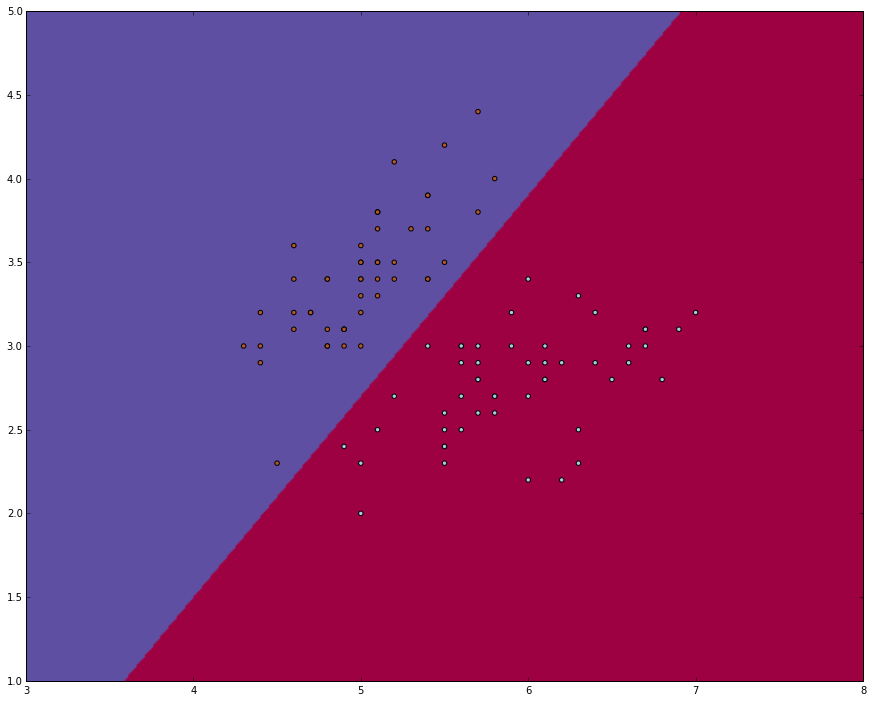

In [63]:
%matplotlib inline

def draw_clf_plane(X, predict):
    import numpy as np
    import matplotlib.pyplot as plt
    import functools as ft
    
    f = plt.figure('Original Hard-Margin SVM', figsize=(15, 15))
    
    x0_min, x0_max = int(min(X[:, 0]) - 1), int(max(X[:, 0]) + 1)
    x1_min, x1_max = int(min(X[:, 1]) - 1), int(max(X[:, 1]) + 1)

    plt.xlim(x0_min, x0_max)
    plt.ylim(x1_min, x1_max)

    # draw classification background
    density = 100
    N1 = (x1_max - x1_min) * density
    N0 = (x0_max - x0_min) * density
    class_map = [[(float(i) / density + x1_min, float(j) / density + x0_min) for j in xrange(N0)] for i in xrange(N1, 0, -1)]
    class_map = map(ft.partial(map, lambda x: predict((x[1], x[0]))), class_map)
    plt.imshow(class_map, cmap=plt.cm.Spectral, extent=[x0_min, x0_max, x1_min, x1_max])

    # drew data
    plt.scatter(X[:, 0], X[:, 1] , c=Y, cmap=plt.cm.Paired)

    #draw classification hyberplane
    #line_x = np.linspace(x0_min, x0_max)
    #line_y = map(lambda x0: (-b - w[0] * x0) / w[1], line_x)
    #plt.plot(line_x, line_y)

    plt.show()

draw_clf_plane(X, predict)

## 二. Dual Hard-Margin SVM

+ 动机：原始二次规划问题的复杂度跟特征的维度有关系，即效率受限于特征的维度．想办法去除这一限制，以便可以对特征进行任意扩充，甚至可以扩充到无限维．

+ 要做到这一点，就要把原问题转化为其对偶问题。对偶有相反的意思，特定于目前的优化问题，就是优化变量的维度从样本的特征维度转到样本的个数。

要做到这点，首先把之前的二次规划问题通过拉格朗日算子转化为最小最大化问题。

$$\min \limits_{w,b} \frac{1}{2} w^T w $$
$$s.t.$$
$$y_n (w^T x_n + b) \geq 1$$

$$\Downarrow 通过拉格朗日算子转化为最小最大化问题$$

$$ \min \limits_{w,b} \max \limits_{\alpha_n \geq 0} \{ \frac{1}{2} w^T w + \sum \limits_{n} \alpha_n (1 - y_n (w^T x_n + b)) \} $$

$$\Downarrow 通过 \min \max \geq \max \min 公式及强对偶条件，转化为等效的 \max \min 问题 $$

$$ \max \limits_{\alpha_n \geq 0} \min \limits_{w,b} \frac{1}{2} w^T w + \sum_n \alpha_n (1 - y_n (w^T x_n + b)) $$

$$\Downarrow 两个问题有相同最优解的充分必要条件（KKT条件）$$

$$ y_n ( w^T x_n + b) \geq 1 $$
$$ \alpha_n \geq 0 $$
$$ \alpha_n ( 1 - y_n (w^T x_n + b)) = 0 $$
$$ \sum \limits_{n} \alpha_n y_n = 0$$
$$ w = \sum \limits_{n} \alpha_n y_n x_n $$

$$\Downarrow 将 \min 问题通过KKT条件进行转化 $$

$$ \max \limits_{\alpha_n \geq 0, \sum \limits_{n} \alpha_n y_n = 0, w = \sum \limits_{n} \alpha_n y_n x_n} - \frac{1}{2} \sum \limits_n \sum \limits_m \alpha_n \alpha_m y_n y_m x_n^T x_m + \sum \limits_{n} \alpha_n $$

$$\Downarrow 问题取反，转化为二次规划问题 $$

$$ \min \frac{1}{2} \alpha^T Q \alpha + p^T \alpha $$
$$ G \alpha \leq h $$
$$ A \alpha = b $$
$$ s.t. $$
$$ Q_{N*N} = \left[ \begin{array}{cc} . & . \\ . & y_n y_m x_n^T x_m \\ \end{array} \right] $$
$$ p_{n*1} = -1 $$
$$ G_{n*n} = -I $$ 
$$ h_{n*1} = 0 $$
$$ A_{n*1} = Y^T $$
$$ b_{1*1} = 0 $$

$$\Downarrow 求得\alpha后，根据KKT条件，得到w, b 和hypothesis函数 $$

$$ w = \sum \limits_{n} \alpha_n y_n x_n $$
$$ b = y_{sv} - w^T x_{sv} $$
$$ G_{svm} (x) = sign(\sum \limits_n \alpha_n y_n K(x_n, x) + \sum \limits_n \alpha_n y_n K(x_n, x_{sv})) $$

$$ s.t. $$
$$ \alpha_{sv} > 0 $$


    上面的K()是kernel trick操作，将特征转化和点积两个操作进行统一，节省了计算量。下面我们先测试线性核的效果和原问题是相同的，线性核即没有特征转换，只是点积运算，公式如下：

$$ K(x, x^{`}) = x^T x^{`} $$


    线性核的问题是隐式扩充特征的能力有限，于是在原始数据可能不线性可分的时候无能为力。
    
    下面首先验证对偶问题（线性核）与原始问题得到的分类面一样。

In [64]:
%%time

#调用QP程序得到分类面(w, b)
d = X.shape[1]
n = X.shape[0]

Q = [[Y[i, 0] * Y[j, 0] * np.dot(X[i], X[j]) for j in xrange(n)] for i in xrange(n)]
p = - np.ones((n, 1))
G = - np.eye(n)
h = np.zeros((n, 1))
A = np.array(Y.T, dtype='d')
b = np.zeros((1, 1))

print G

Q = matrix(Q)
p = matrix(p)
G = matrix(G)
h = matrix(h)
A = matrix(A)
b = matrix(b)


sol = solvers.qp(Q, p, G, h, A, b)

alpha = np.array(sol['x']).reshape((n, 1))

sv_idx = alpha.argmax()

w = np.sum(alpha * Y * X, axis=0)
b = Y[sv_idx,0] - np.dot(w, X[sv_idx])
print '-' * 100
print 'b:'
print b
print 'w:'
print w


[[-1. -0. -0. ..., -0. -0. -0.]
 [-0. -1. -0. ..., -0. -0. -0.]
 [-0. -0. -1. ..., -0. -0. -0.]
 ..., 
 [-0. -0. -0. ..., -1. -0. -0.]
 [-0. -0. -0. ..., -0. -1. -0.]
 [-0. -0. -0. ..., -0. -0. -1.]]
     pcost       dcost       gap    pres   dres
 0: -1.7775e+01 -3.8527e+01  3e+02  2e+01  2e+00
 1: -3.0310e+01 -3.6184e+01  1e+02  7e+00  8e-01
 2: -5.7279e+01 -5.4062e+01  1e+02  4e+00  5e-01
 3: -4.3187e+01 -4.2685e+01  5e+01  1e+00  2e-01
 4: -3.3936e+01 -3.4346e+01  4e+00  1e-01  1e-02
 5: -3.3794e+01 -3.3801e+01  4e-02  1e-03  1e-04
 6: -3.3795e+01 -3.3795e+01  4e-04  1e-05  1e-06
 7: -3.3795e+01 -3.3795e+01  4e-06  1e-07  1e-08
 8: -3.3795e+01 -3.3795e+01  4e-08  1e-09  1e-10
Optimal solution found.
----------------------------------------------------------------------------------------------------
b:
17.3157894733
w:
[-6.31578947  5.26315789]
CPU times: user 37.5 ms, sys: 2.95 ms, total: 40.5 ms
Wall time: 39.6 ms


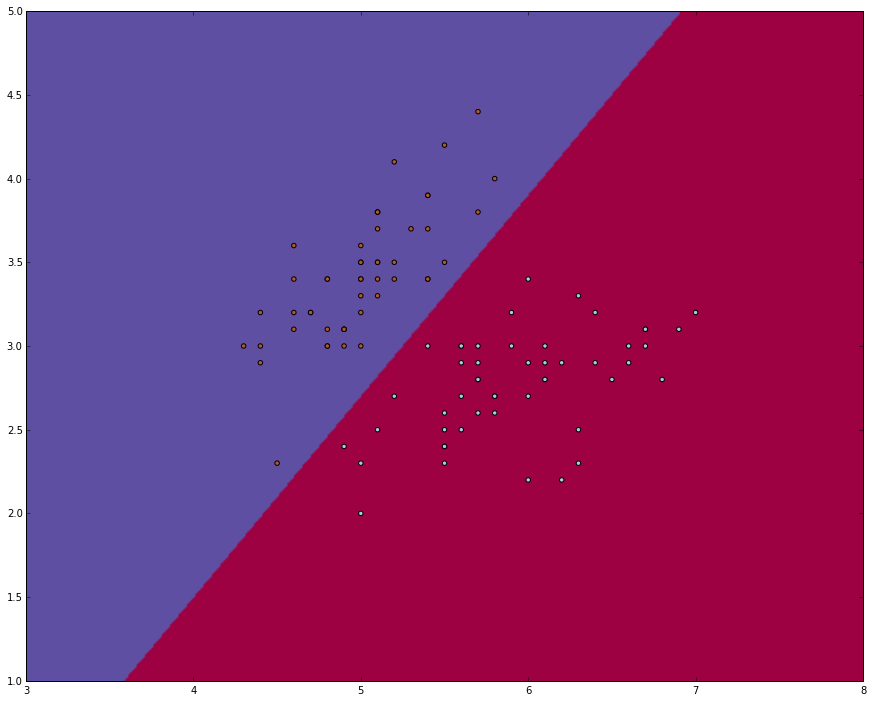

In [65]:
draw_clf_plane(X, predict)

+ 高级的核技巧类型：多项式核和高斯核(RBF, Radial Basis Function Kernel)。

$$ K(x, x^{`}) = ( \zeta + \gamma x^T x^{`} )^Q $$
$$ s.t. $$
$$ \beta \geq 0 $$
$$ \gamma > 0 $$
$$ Q > 0 $$

 $ \gamma, Q$ 越大，分类面越复杂（过拟合）；$\zeta$一般取0。多项式核的优点是比线性核强大，表达能力可以通过Q显性控制。缺点是可调参数略多（三个），还有数值计算方面的问题（小于1和大于1的数求指数的指数爆炸问题）。

所以，使用多项式核的时候要选取较小的$Q$，另外可以考虑通过手动扩充多项式特征＋线性核的方法取代多项式核心问题（可能提高效率）。

$$ K(x, x^{`}) = exp( - \gamma ||x - x^`||^2 ) $$
$$ \gamma > 0 $$

$ \gamma $ 跟方差成反比，前者越大，高斯函数越陡，分类面越复杂（过拟合）。高斯核的另一个问题是$w$不可知。

In [69]:
linear_kernel = lambda x1, x2: np.dot(x1, x2)

def multi_kernel(beta, gamma, Q):
    return lambda x1, x2: pow(beta + gamma * np.dot(x1, x2), Q)

def rbf_kernel(gamma):
    return lambda x1, x2: np.exp(-gamma * np.dot(np.subtract(x1, x2), np.subtract(x1, x2)))

def train_with_kernel(X, Y, kernel):
    #调用QP程序得到alphas
    d = X.shape[1]
    n = X.shape[0]

    Q = [[Y[i, 0] * Y[j, 0] * kernel(X[i], X[j]) for j in xrange(n)] for i in xrange(n)]
    p = - np.ones((n, 1))
    G = - np.eye(n)
    h = np.zeros((n, 1))
    A = np.array(Y.T, dtype='d')
    b = np.zeros((1, 1))

    Q = matrix(Q)
    p = matrix(p)
    G = matrix(G)
    h = matrix(h)
    A = matrix(A)
    b = matrix(b)

    sol = solvers.qp(Q, p, G, h, A, b)

    alpha = np.array(sol['x']).reshape((n, 1))
    
    return alpha

def predict_with_kernel(x, alpha, X, Y, kernel):
    import functools as ft
    sv_idx = np.argmax(alpha)
    
    b = Y[sv_idx, 0] - np.sum(Y * alpha * np.reshape(map(ft.partial(kernel, X[sv_idx]), X), (len(Y), 1)))

    y = np.sum(Y * alpha * np.reshape(map(ft.partial(kernel, x), X), (len(Y), 1))) + b
    
    return 0 if y < 0 else 1

     pcost       dcost       gap    pres   dres
 0: -1.1041e+01 -2.8489e+01  2e+02  1e+01  2e+00
 1: -1.4523e+01 -2.9465e+01  6e+01  3e+00  5e-01
 2: -1.9631e+01 -3.8297e+01  4e+01  1e+00  2e-01
 3: -2.4241e+01 -3.2164e+01  1e+01  3e-01  5e-02
 4: -2.8235e+01 -2.9648e+01  2e+00  1e-02  2e-03
 5: -2.9276e+01 -2.9352e+01  8e-02  3e-05  4e-06
 6: -2.9342e+01 -2.9343e+01  1e-03  3e-07  5e-08
 7: -2.9343e+01 -2.9343e+01  1e-05  3e-09  5e-10
Optimal solution found.


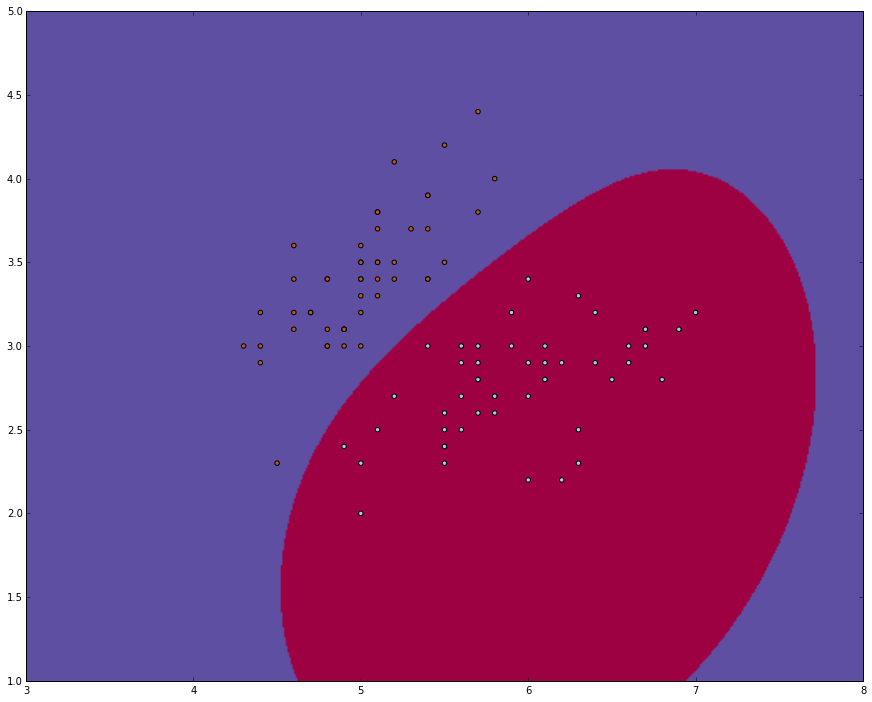

In [70]:
kernel = rbf_kernel(0.5)

alpha = train_with_kernel(X, Y, kernel)

def predict(x):
    return predict_with_kernel(x, alpha, X, Y, kernel)

draw_clf_plane(X, predict)

     pcost       dcost       gap    pres   dres
 0: -1.8315e+01 -3.6672e+01  3e+02  2e+01  2e+00
 1: -2.8844e+01 -2.4272e+01  1e+02  7e+00  8e-01
 2: -4.9661e+01 -2.4487e+01  9e+01  4e+00  5e-01
 3: -1.8628e+01 -3.4758e+00  4e+01  1e+00  2e-01
 4: -1.3700e+00 -5.7879e-01  3e+00  8e-02  1e-02
 5: -4.2616e-01 -5.0776e-01  1e-01  9e-04  1e-04
 6: -4.7476e-01 -4.8302e-01  1e-02  6e-05  7e-06
 7: -4.8154e-01 -4.8164e-01  1e-04  6e-07  7e-08
 8: -4.8162e-01 -4.8162e-01  1e-06  6e-09  7e-10
 9: -4.8162e-01 -4.8162e-01  1e-08  6e-11  7e-12
Optimal solution found.


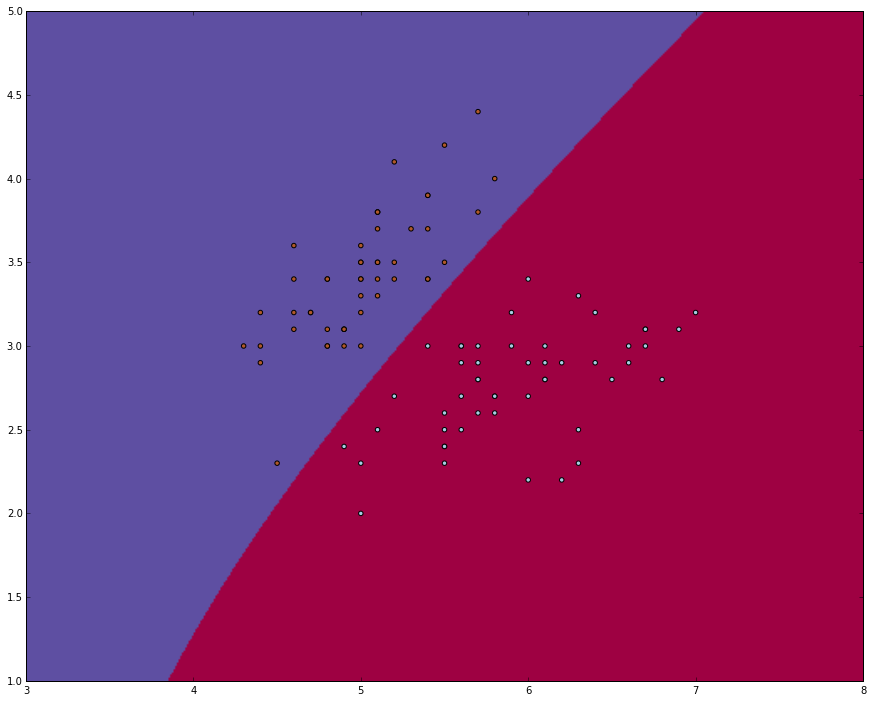

In [71]:
kernel = multi_kernel(0, 1, 2)

alpha = train_with_kernel(X, Y, kernel)

def predict(x):
    return predict_with_kernel(x, alpha, X, Y, kernel)

draw_clf_plane(X, predict)


    可以构造自定义的核函数，但是要符合 Mercer's condition。

## 三. Soft-Margin SVM

+ 动机：Kernel Hard-Margin SVM 会出现过拟合的问题，原因一方面是核的特征转化能力太强，另一方面是Hard-Margin SVM会彻底的分开数据（准确率100%）．为了应对过拟合问题，会想到允许分错数据这一思想．

我们定义一个 $\xi_n$ 代表数据点 $n$ 离分类面（确切的说是其所属类别的胖分类面的边界）的距离（不太准确，应该是距离和 $|w|$ 的乘积），得到如下优化问题：

$$ \min_{w, b} \frac{1}{2} w^T w + C \sum_n \xi_n $$

$$ s.t. $$
$$ y_n ( w^T x + b) \geq 1 - \xi_n $$
$$ \xi_n \geq 0 $$

$$ \Downarrow 拉格朗日乘子转化 $$

$$ \min_{w,b,\xi_n \geq 0} \max_{\alpha_n \geq 0, \beta_n \geq 0} \frac{1}{2} w^T w + C \sum_n \xi_n + \sum_n \alpha_n (1 - \xi_n - y_n (w^T x_n + b)) - \sum_n \beta_n \xi_n $$

$$ \Downarrow 强对偶转化 $$

$$ \max_{\alpha_n \geq 0, \beta_n \geq 0} \min_{w,b,\xi_n \geq 0} \frac{1}{2} w^T w + C \sum_n \xi_n + \sum_n \alpha_n (1 - \xi_n - y_n (w^T x_n + b)) - \sum_n \beta_n \xi_n $$

$$ \Downarrow 上述两个问题有相同最优解（变量的解）的KKT条件如下 $$

$$ \alpha_n (1 - \xi_n - y_n (w^T x + b)) = 0 $$
$$ \beta_n \xi_n = 0 $$
$$ C - \alpha_n - \beta_n = 0 $$
$$ \alpha_n \geq 0 $$
$$ \beta_n \geq 0 $$
$$ \xi_n \geq 0 $$
$$ w = \sum_n \alpha_n y_n x_n $$
$$ \sum_n \alpha_n y_n = 0 $$

$$ \Downarrow 用\alpha表示\beta，以上KKT条件转化为：$$

$$ \alpha_n (1 - \xi_n - y_n (w^T + b)) = 0 $$
$$ (C - \alpha_n) \xi_n = 0 $$
$$ 0 \leq \alpha_n \leq C $$
$$ \xi_n \geq 0 $$
$$ w = \sum_n \alpha_n y_n x_n $$
$$ \sum_n \alpha_n y_n = 0 $$

$$ \Downarrow 从前两个条件（complementary slackness）可以得到数据中的三种点（按照空间位置分）： $$

$$胖边界上的点n ：0 \leq \alpha_n \leq C$$
$$分对的点（不包含胖边界上的点）：\alpha_n = 0$$
$$ 分错的点：\alpha_n = C$$

$$ 从上面可以归纳出，真正的free SV(自由支持向量，100\%确定是支持向量）满足: 0 < \alpha_n < C，其可以用来计算w。$$

$$ \Downarrow 利用KKT条件对\max \min 问题进行转化 $$

$$ \max \limits_{0 \leq \alpha_n \leq C , \sum_n \alpha_n y_n = 0} - \frac{1}{2} \sum_n \sum_m \alpha_n \alpha_m y_n y_m x_n^T x_m + \sum_n \alpha_n $$

$$ \Downarrow 转化为二次规划问题 $$

$$ \min \frac{1}{2} \alpha^T Q \alpha + p^T \alpha $$
$$ G \alpha \leq h $$
$$ A \alpha = b $$
$$ s.t. $$
$$ Q_{N*N} = \left[ \begin{array}{cc} . & . \\ . & y_n y_m x_n^T x_m \\ \end{array} \right] $$
$$ p_{n*1} = -1 $$
$$ G_{2n*n} = \left[ \begin{array}{c} I \\ -I \\ \end{array} \right] $$
$$ h_{2n*1} = \left[ \begin{array}{c} C_{n*1} \\ 0_{n*1} \\ \end{array} \right] $$
$$ A_{n*1} = Y^T $$
$$ b_{1*1} = 0 $$

$$ 得到相同的hypothesis函数：G_{svm} (x) = sign(\sum \limits_n \alpha_n y_n K(x_n, x) + \sum \limits_n \alpha_n y_n K(x_n, x_{sv})) $$


In [72]:
%%time

def train_with_kernel(X, Y, kernel, C=1):
    
    #调用QP程序得到alphas
    d = X.shape[1]
    n = X.shape[0]
    
    Q = [[Y[i, 0] * Y[j, 0] * kernel(X[i], X[j]) for j in xrange(n)] for i in xrange(n)]
    p = - np.ones((n, 1))
    G = np.vstack((np.eye(n), -np.eye(n)))
    h = np.reshape([C] * n + [0] * n, (2 * n, 1))
    h = np.array(h, dtype='d')
    A = np.array(Y.T, dtype='d')
    b = np.zeros((1, 1))

    Q = matrix(Q)
    p = matrix(p)
    G = matrix(G)
    h = matrix(h)
    A = matrix(A)
    b = matrix(b)


    sol = solvers.qp(Q, p, G, h, A, b)

    alpha = np.array(sol['x']).reshape((n, 1))
    
    return alpha

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


     pcost       dcost       gap    pres   dres
 0:  1.0050e+01 -5.9222e+03  1e+04  7e-01  4e-13
 1:  1.6762e+02 -1.2805e+03  2e+03  4e-02  5e-13
 2:  4.3129e+01 -1.4739e+02  2e+02  2e-03  4e-13
 3: -2.8377e+00 -4.8404e+01  5e+01  4e-04  2e-13
 4: -9.7780e+00 -4.9198e+01  4e+01  3e-04  2e-13
 5: -1.0799e+01 -4.8608e+01  4e+01  2e-04  2e-13
 6: -1.6841e+01 -4.2429e+01  3e+01  1e-04  2e-13
 7: -2.5359e+01 -3.0211e+01  5e+00  3e-06  2e-13
 8: -2.7166e+01 -2.8974e+01  2e+00  4e-07  2e-13
 9: -2.7980e+01 -2.8024e+01  4e-02  1e-08  1e-13
10: -2.8000e+01 -2.8000e+01  4e-04  1e-10  1e-13
11: -2.8000e+01 -2.8000e+01  4e-06  1e-12  2e-13
Optimal solution found.


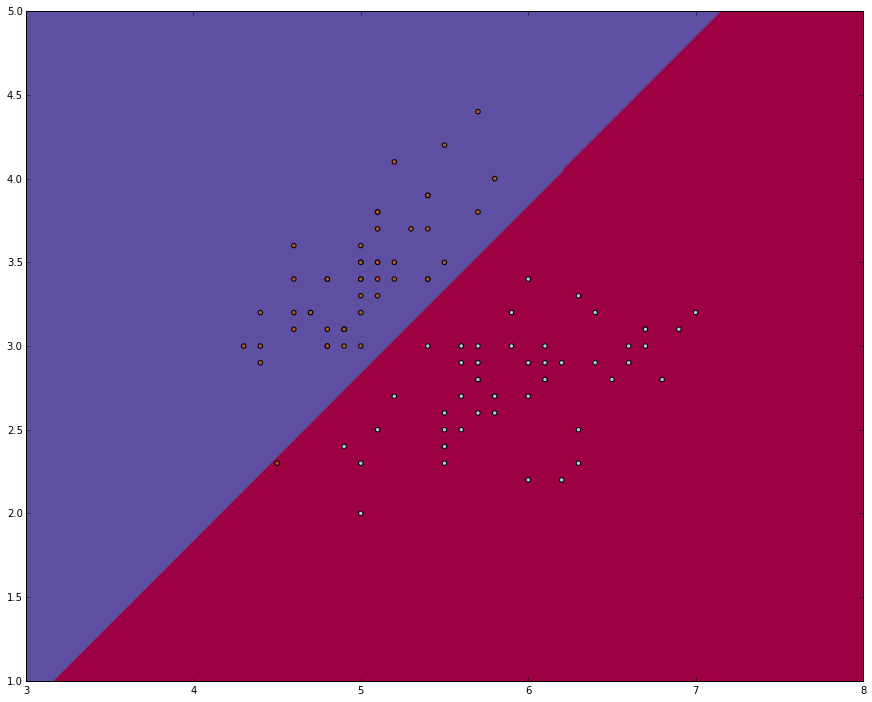

In [73]:
kernel = linear_kernel

alpha = train_with_kernel(X, Y, kernel, C=10)

def predict(x):
    return predict_with_kernel(x, alpha, X, Y, kernel)

draw_clf_plane(X, predict)

上图可以看出，在线性核的情况下，有一个点分错了，这是在Hard-Margin SVM里面不会出现的情况。可以通过调节C消除这种情况。

     pcost       dcost       gap    pres   dres
 0: -1.8285e+01 -1.8554e+02  9e+02  2e+00  3e-12
 1: -1.0862e+01 -9.8609e+01  2e+02  3e-01  2e-12
 2: -5.2609e+00 -2.8928e+01  5e+01  9e-02  1e-12
 3: -2.9543e+00 -1.2497e+01  2e+01  3e-02  7e-13
 4: -1.7974e+00 -6.1152e+00  9e+00  2e-02  5e-13
 5: -4.8271e-01 -2.9963e+00  4e+00  5e-03  2e-13
 6: -3.6187e-01 -9.8397e-01  9e-01  8e-04  1e-13
 7: -3.3596e-01 -7.9208e-01  5e-01  3e-04  9e-14
 8: -4.7852e-01 -4.8895e-01  1e-02  3e-06  1e-13
 9: -4.8159e-01 -4.8170e-01  1e-04  3e-08  1e-13
10: -4.8162e-01 -4.8162e-01  1e-06  3e-10  1e-13
11: -4.8162e-01 -4.8162e-01  1e-08  3e-12  1e-13
Optimal solution found.


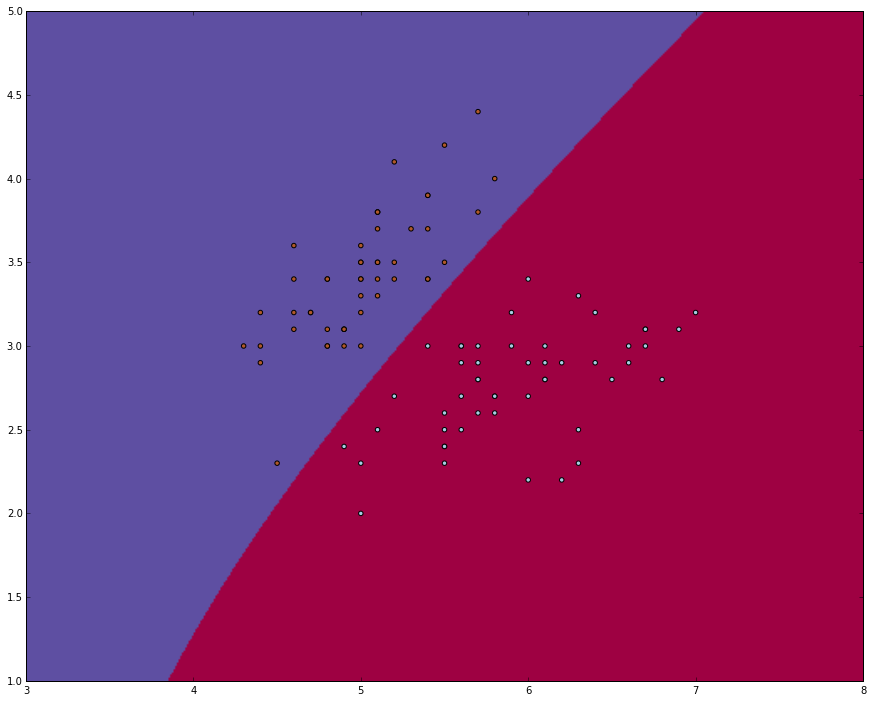

In [74]:
kernel = multi_kernel(0, 1, 2)

alpha = train_with_kernel(X, Y, kernel, C=1)

def predict(x):
    return predict_with_kernel(x, alpha, X, Y, kernel)

draw_clf_plane(X, predict)


     pcost       dcost       gap    pres   dres
 0:  1.6465e+02 -3.6533e+03  7e+03  3e-01  7e-15
 1:  1.6309e+02 -4.2188e+02  6e+02  9e-03  8e-15
 2:  1.2305e+01 -6.4294e+01  8e+01  1e-04  5e-15
 3: -5.5447e+00 -5.0524e+01  5e+01  5e-05  3e-15
 4: -1.4666e+01 -4.3236e+01  3e+01  2e-05  3e-15
 5: -2.0107e+01 -3.7999e+01  2e+01  9e-06  3e-15
 6: -2.4896e+01 -3.1898e+01  7e+00  1e-14  4e-15
 7: -2.7326e+01 -2.8411e+01  1e+00  1e-14  4e-15
 8: -2.7751e+01 -2.7850e+01  1e-01  4e-15  4e-15
 9: -2.7796e+01 -2.7797e+01  1e-03  1e-14  4e-15
10: -2.7796e+01 -2.7796e+01  1e-05  9e-15  4e-15
Optimal solution found.


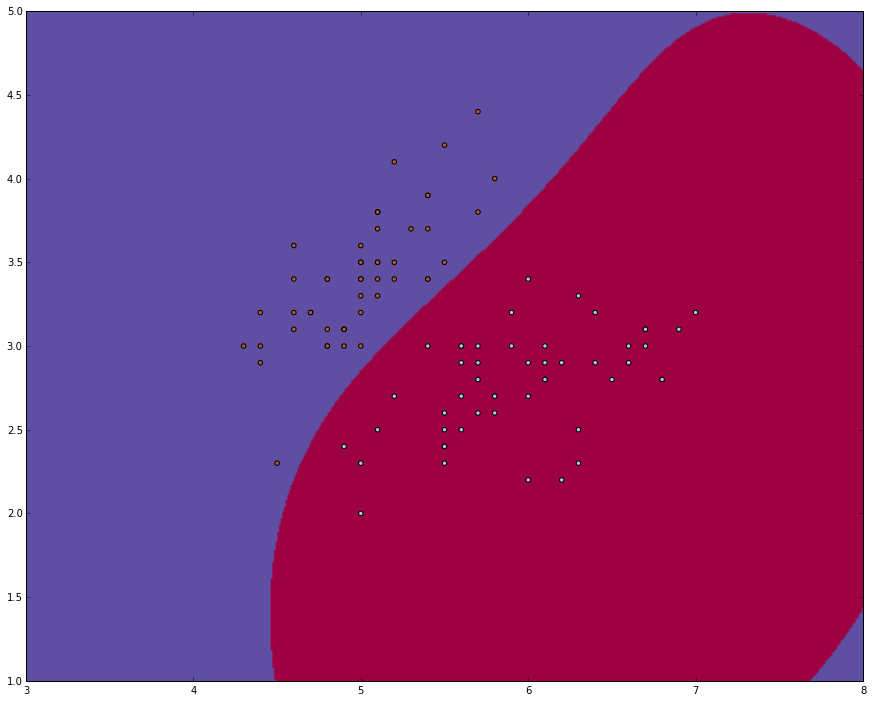

In [75]:
kernel = rbf_kernel(0.5)

alpha = train_with_kernel(X, Y, kernel, C=10)

def predict(x):
    return predict_with_kernel(x, alpha, X, Y, kernel)

draw_clf_plane(X, predict)

scikit-learn的相应方法例子：

Automatically created module for IPython interactive environment


/Users/DY/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/DY/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/DY/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/DY/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


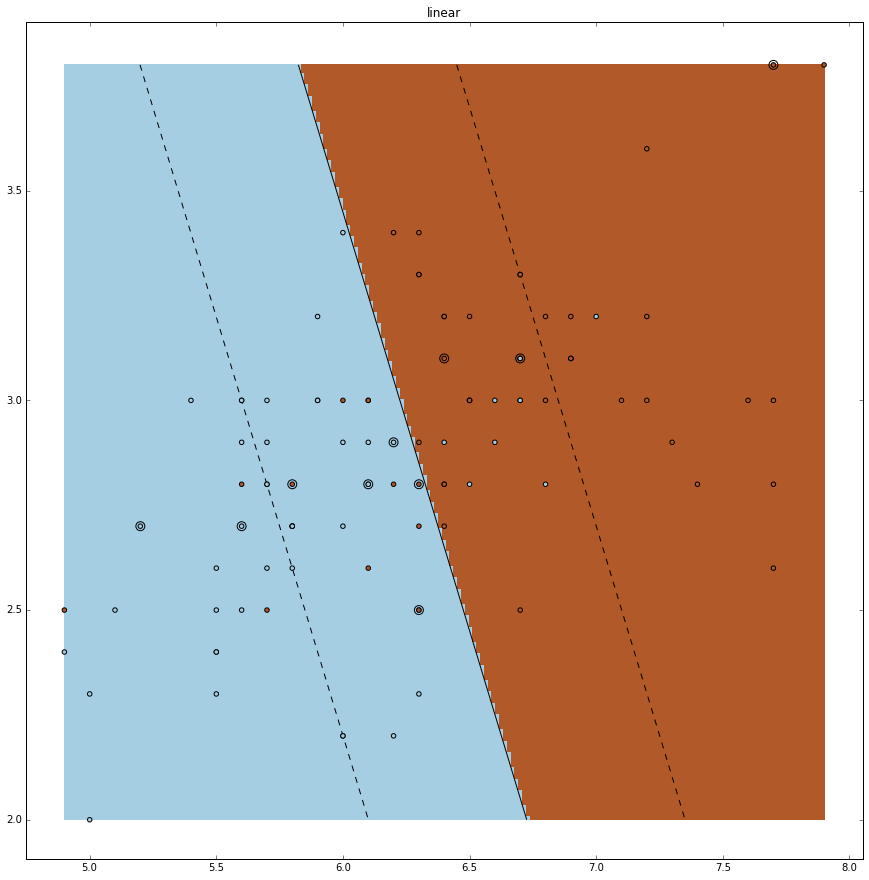

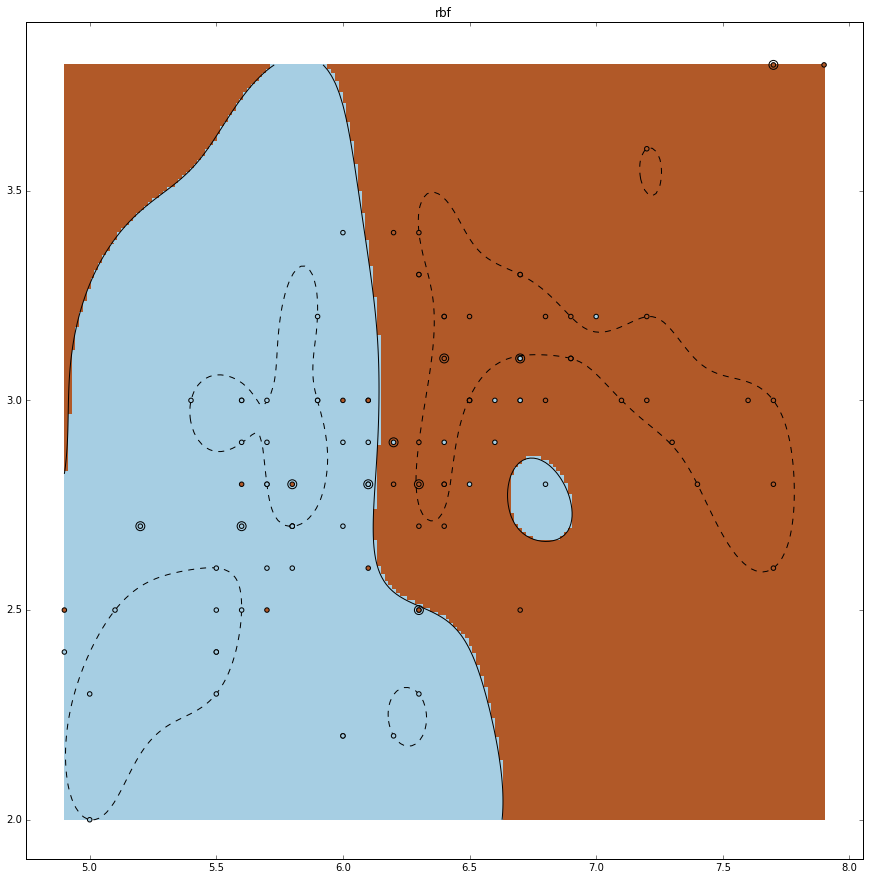

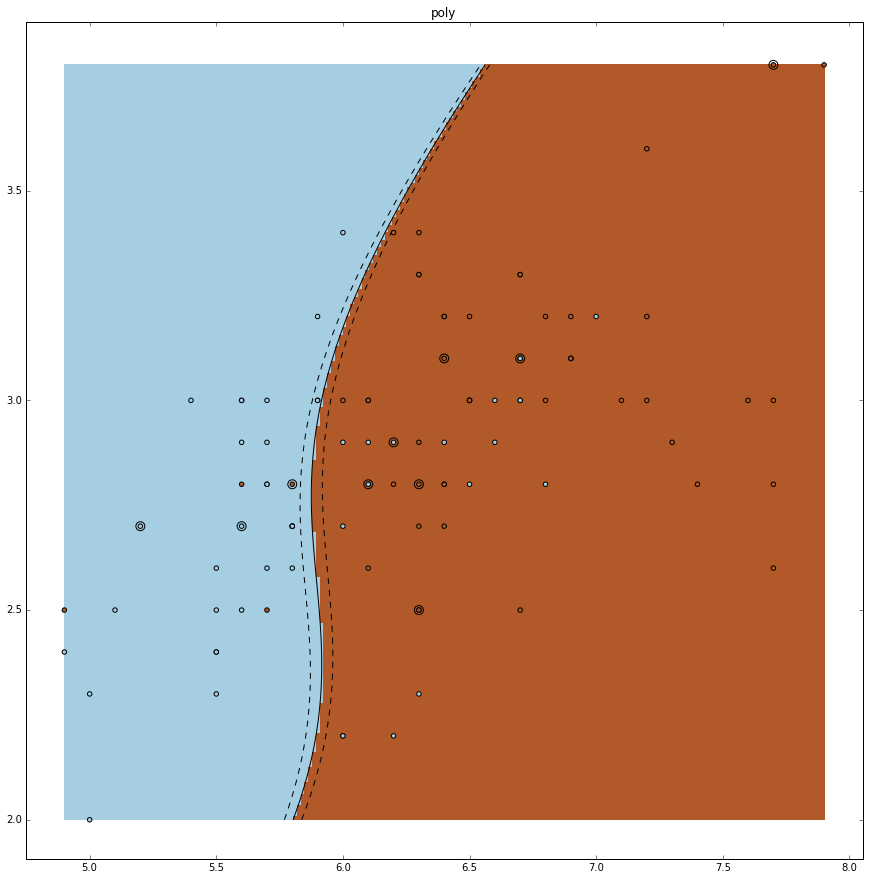

In [77]:
%matplotlib inline
print(__doc__)


import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 0, :2]
y = y[y != 0]

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)

X_train = X[:.9 * n_sample]
y_train = y[:.9 * n_sample]
X_test = X[.9 * n_sample:]
y_test = y[.9 * n_sample:]

# fit the model
for fig_num, kernel in enumerate(('linear', 'rbf', 'poly')):
    clf = svm.SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure(fig_num, figsize=(15, 15))
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired)

    # Circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10)

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1., 0, 1.])

    plt.title(kernel)
plt.show()


## 四. Kernel Logistic Regression

+ 动机：将核技巧用于软分类。

cross-entropy 损失函数： $ CE(y, s) = ln (1 + exp(-y s)) $， 函数图像如下：

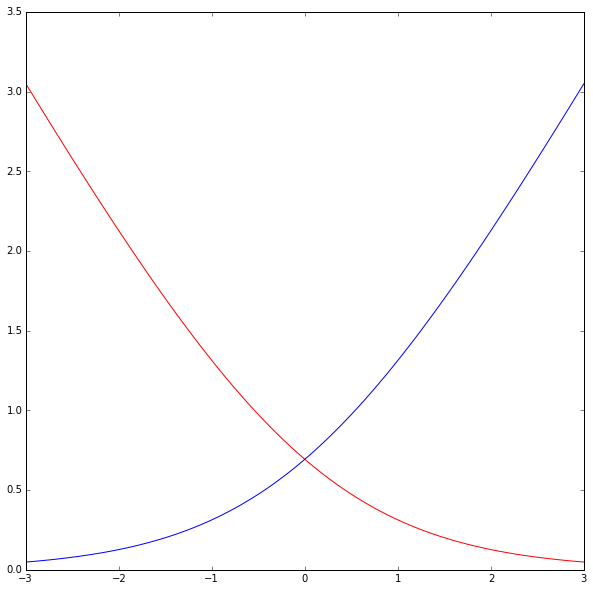

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

f = plt.figure(figsize=(10,10))
x = np.linspace(-3, 3, 100)

y_ce_plus1 = map(lambda x: np.log(1 + np.exp(-1 * x)), x)
y_ce_minus1 = map(lambda x: np.log(1 + np.exp(1 * x)), x)

plt.plot(x, y_ce_plus1, 'r')
plt.plot(x, y_ce_minus1, 'b')
plt.show()

L2 正则化的逻辑回归公式如下：

$$ \min_{w,b} \frac{1}{2} w^t w + \sum_n ln(1 + exp(-y_n (w^T x_n + b) )) $$

上述函数复合representer theory的要求，可以直接把$ w = \sum_n \beta_n x_n $直接带入上面，然后解一个关于$\beta$的无限制二次式（梯度下降），并且通过$x$的内积方便的引入了核技巧。这种方法的缺点是得到的$\beta$非常稠密，以致支持向量非常多（错误上届大，实际中也不比下面的方法好）。

还有一种方法是把SVM当作一种特征转化：

1. 先对数据点进行从$d$维到$1$维的转化：$\Phi_{svm} (x) = w_{svm}^T \Phi (x) + b_{svm}$

2. 然后带入没有正则化的逻辑回归问题：$$ \min_{A,B} + \sum_n ln(1 + exp ( -y_n (A \Phi_svm (x) + B) )) $$
    其中A和B对转化后的数据点进行放缩和平移，此时的他们是新的待求解变量。

3. 预测的时候用：$G (x) = \theta (A \Phi_{svm} (x) + B ) $

上面的方法叫Platt's Model，她也很好的融入了核技巧，并且她的合理结果是$ A > 0 且 B \approx 0$。要不然就代表作特征转化的SVM的效果不好。

Platt's Model在实际中应用比较多，她在scikit-learn中的接口如下：

In [79]:
from sklearn.svm import SVC

clf = SVC(probability=True)
Y = np.reshape(Y, (len(Y),))
clf.fit(X, Y)
print clf.classes_
print clf
print '-' * 100
print 'class prob:'
print clf.predict_proba(X[0])

[-1  1]
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
----------------------------------------------------------------------------------------------------
class prob:
[[ 0.56199093  0.43800907]]


## 五. Support Vector Regression

+ 动机: 将核技巧用于回归问题（L2正则化）, 同时得到较为稀疏的解 (支持向量较少)

将核技巧用于回归问题比较简单,直接基于representer thoery, 即$ w = \sum_n \beta_n x_n $. 但是这样得到的 $\beta$ 非常稠密, 造成支持向量比较多. 解决这一问题的方法是放弃一步到位的representer thoery, 通过tube损失函数引入不等式限制, 紧接着转化为与SVM类似的原始二次规划问题. 这样达到的目的是我们可以通过KKT条件中的complementary slackness条件得到较为稀疏的 $\alpha$, 支持向量也跟着少了.

+ tube 损失函数

$$ tube(y, s) = \max (|y - s| - \epsilon, 0) $$

类似于 Soft-Margin SVM 里面的hinge损失函数: $ hinge(y, s) = \max (1 - y s, 0) $，其和回归问题中应用的平方损失函数 $SE(y, s) = (y - s)^2$ 的区别如下图：

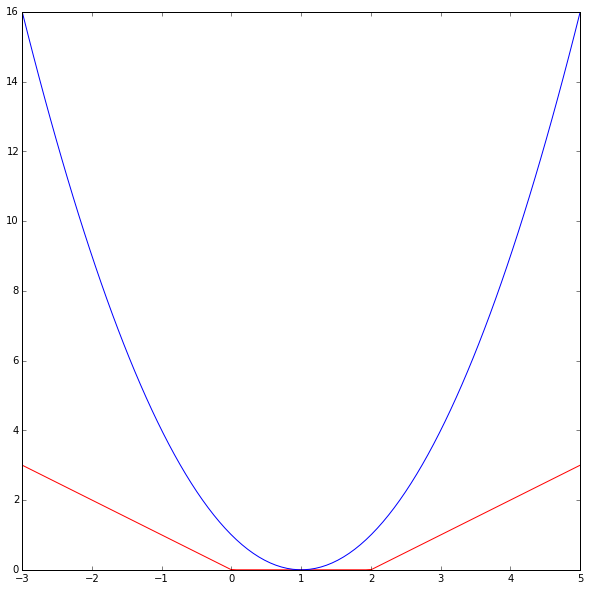

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

f = plt.figure(figsize=(10,10))
x = np.linspace(-3, 5, 100)
epsilon = 1
y = 1
y_tube = map(lambda x: max(abs(y - x) - epsilon, 0), x)
y_se = map(lambda x: pow(y - x, 2), x)

plt.plot(x, y_tube, 'r')
plt.plot(x, y_se, 'b')

plt.show()

绿色的是平方损失函数，红色的是tube损失函数。tube比较缓和，不容易受噪点的干扰，不容易过拟合。

将原始回归问题的square损失函数通过tube进行变形, 然后一步步转化为有条件限制的二次规划问题.

$$ \min_{w, b} \frac{\lambda}{N} w^T w + \frac{1}{N} \sum_n (y_n - w^T x_n - b)^2 $$ 

$$ \Downarrow tube替换平方损失函数, \lambda 用C替换 $$

$$ \min_{w, b} \frac{1}{2} w^T w + C \sum_n \max (|y_n - w^T x_n - b| - \epsilon , 0) $$ 

$$ \Downarrow 讲tube转化为不等式限制条件 $$

$$ \min_{w, b, \xi} \frac{1}{2} w^T w + C \sum_n \xi_n $$ 
$$ s.t. $$
$$ | y_n - w^T x_n - b | \leq \epsilon + \xi_n $$
$$ \xi_n \geq 0 $$

$$ \Downarrow 将不等式限制条件中的绝对值符号去掉 $$

$$ \min_{w, b, \xi} \frac{1}{2} w^T w + C \sum_n (\check{\xi_n} + \hat{\xi_n}) $$ 
$$ s.t. $$
$$ -\epsilon - \check{\xi_n} \leq y_n - w^T x_n - b \leq \epsilon + \hat{\xi_n} $$
$$ \check{\xi_n} \geq 0 $$
$$ \hat{\xi_n} \geq 0 $$

$$ \Downarrow 转化为\min \max问题, 接着转化为\max \min问题 $$

$$ min_{w, b, \xi} \max_{\check{\alpha_n} \geq 0, \hat{\alpha_n} \geq 0, \beta_n \geq 0} \frac{1}{2} w^T w + C \sum_n (\check{\xi_n} + \hat{\xi_n}) + \sum_n \check{\alpha_n} (-\epsilon - \check{\xi_n} - y_n + w^T  x_n + b) + \sum_n \hat{\alpha_n} (y_n - w^T x_n - b - \epsilon - \hat{\xi_n})  \\ 
- \sum_n \check{\beta_n} \check{\xi_n}  - \sum_n \hat{\beta_n} \hat{\xi_n} $$

$$ \max_{\check{\alpha_n} \geq 0, \hat{\alpha_n} \geq 0, \beta_n \geq 0}  min_{w, b, \xi} \frac{1}{2} w^T w + C \sum_n (\check{\xi_n} + \hat{\xi_n}) + \sum_n \check{\alpha_n} (-\epsilon - \check{\xi_n} - y_n + w^T  x_n + b) + \sum_n \hat{\alpha_n} (y_n - w^T x_n - b - \epsilon - \hat{\xi_n}) \\ 
- \sum_n \check{\beta_n} \check{\xi_n} - \sum_n \hat{\beta_n} \hat{\xi_n}$$

$$ \Downarrow KKT中的complementary-slackness条件 $$

$$ w = \sum_n (\check{\alpha_n} - \hat{\alpha_n}) x_n $$
$$ \sum_n (\check{\alpha_n} - \hat{\alpha_n}) = 0 $$
$$ C - \check{\alpha_n}  - \check{\beta_n} = 0 $$
$$ C - \hat{\alpha_n}  - \hat{\beta_n} = 0 $$

$$ \check{\alpha_n} (-\epsilon - \check{\xi_n} - y_n + w^T  x_n + b) = 0 $$
$$ \hat{\alpha_n} (y_n - w^T x_n - b - \epsilon - \hat{\xi_n}) = 0 $$
$$ \check{\beta_n} \check{\xi_n} = 0 $$
$$ \hat{\beta_n} \hat{\xi_n} = 0 $$

从上面可以看出只有落在tube中的点, 其representer thoery中的$\beta_n$，即 $\check{\alpha_n} - \hat{\alpha_n}$ 等于0. 可以类比Soft-Margin-SVM里面支持向量（自由、限制）和普通点的判别方法，这里只有$\beta_n \neq 0$的点是支持向量，具体分类标准如下：

$$ \beta_n = \check{\alpha_n} - \hat{\alpha_n} $$
$$ 自由支持向量（100\%是支持向量，可用于计算b）: 0 < |\beta_n| < C $$
$$ 限制自由变量（有可能落在胖边界上、有可能分错的点）：|\beta_n| ＝ C $$
$$ tube内部的点(100\%分对的点，有可能落在胖边界上）：\beta_n = 0 $$
